In [2]:
import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg, fmin_ncg
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression


In [92]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll

def objective_logit_1 (params, f, x, y, latent_dim, lambda_e, opt, print_z=False): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    _, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
    
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) #+ w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll


def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

def compute_pl_logit(f, bias_x, cov_noise, w, x, y):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    return np.sum(log_bern_pdf_y)

In [10]:
def generate_samples_gauss(n_samples_class):
    cov = np.array([[6, 1], [1, 2]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 3])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

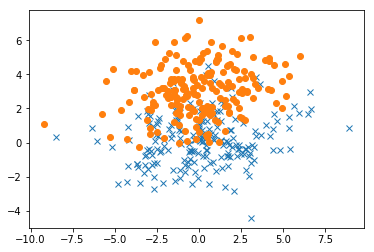

In [11]:
n_samples_class = 200
x, y  =  generate_samples_gauss(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
plt.show()

In [12]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
size_f = latent_dim*x_dim

params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

In [13]:
opt = "ppca"
if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca

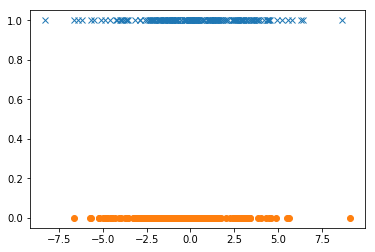

-1799.4091871863823

In [14]:
transformer = PCA(n_components=latent_dim)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')
plt.show()

f_sklearn = transformer.components_.T
cov_noise_sklearn = np.diag(np.ones(x_dim)*transformer.noise_variance_)
bias_sklearn = np.mean(x, axis =0)
compute_ll(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

In [15]:
print "F sklearn", f_sklearn 
print "mean of x \n", bias_sklearn 
print "cov noise sklearn\n", cov_noise_sklearn 
#print transformer.loglike_

F sklearn [[-0.96287604]
 [-0.26994394]]
mean of x 
[0.10186554 1.59833618]
cov noise sklearn
[[4.11131851 0.        ]
 [0.         4.11131851]]


In [16]:
params = np.random.rand(params_size)
f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0, opt)


Initial parameters
F: [[0.74248078]
 [0.67628933]]
slope [0.91085096]
bias:  [0.79502194 0.99091741]
cov_noise matrix:  [[0.80549911 0.        ]
 [0.         0.80549911]]
bias for y:
0.9975718649979002
logistic regression weights:
[0.25155055]
initial obj value logit 2826.8784807825023


In [57]:
lambda_e_1 = 0.30927
lambda_e_2 = 0.30928
step  = 0.000001
lambda_es = np.arange(lambda_e_1,lambda_e_2,step)
acc_scores = np.zeros(lambda_es.shape[0])
obj_values_logit = np.zeros(lambda_es.shape[0])
ll_logit = np.zeros(lambda_es.shape[0])
pred_l_logit = np.zeros(lambda_es.shape[0])

#grad_objective_logit_1 = grad(objective_logit_1, argnum = 0)
#hess_objective_logit_1 = hessian(objective_logit_1, argnum = 0)

def callback(params):
    print objective_logit_1(params, transformer.noise_variance_, x, y, latent_dim, lambda_es[i], opt)
    print grad_objective_logit_1(params, transformer.noise_variance_, x, y, latent_dim, lambda_es[i], opt)
    #print params[1]/params[0]
    #print params[-2],"-",params[-1]
    pass
    print '\n'
grad_objective_logit = grad(objective_logit, argnum = 0)


for i in range(lambda_es.shape[0]):
    params_optimizied_logit, obj, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_es[i], opt))#, callback=callback)
    f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
    #cov_noise_logit = np.diag(np.ones(x_dim)*transformer.noise_variance_)
    x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
    clf_pc = LogisticRegression().fit(x_proj_logit, y)
    acc_scores[i] = clf_pc.score(x_proj_logit, y)
    ll_logit[i] = compute_ll(f_logit, bias_logit, cov_noise_logit, x)
    obj_values_logit[i]=  obj
    pred_l_logit[i] =  compute_pl_logit(f_logit, bias_logit, cov_noise_logit, w_logit, x, y) 

In [32]:
lambda_es.shape[0]

11

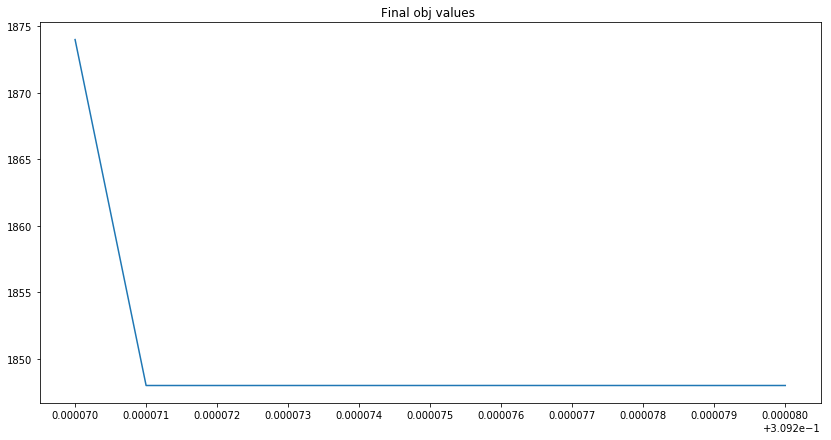

In [61]:
plt.figure(figsize=(14,7))
plt.title("Final obj values ")
plt.xticks(lambda_es)
plt.plot(lambda_es, obj_values_logit)
plt.show()

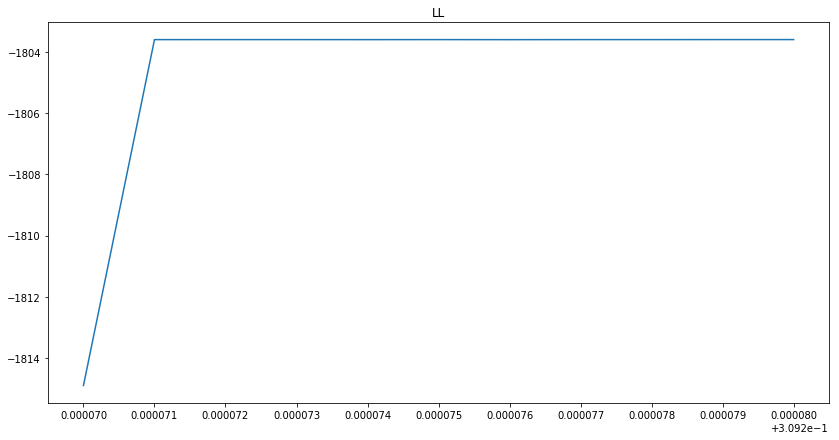

In [62]:
plt.figure(figsize=(14,7))
plt.title("LL")
plt.xticks(lambda_es)
plt.plot(lambda_es, ll_logit)
plt.show()

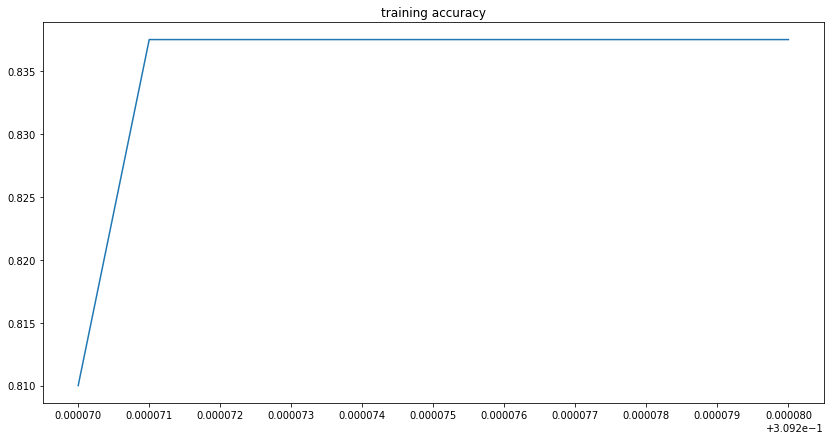

In [63]:
plt.figure(figsize=(14,7))
plt.title("training accuracy")
plt.xticks( lambda_es)
plt.plot(lambda_es, acc_scores)
plt.show()

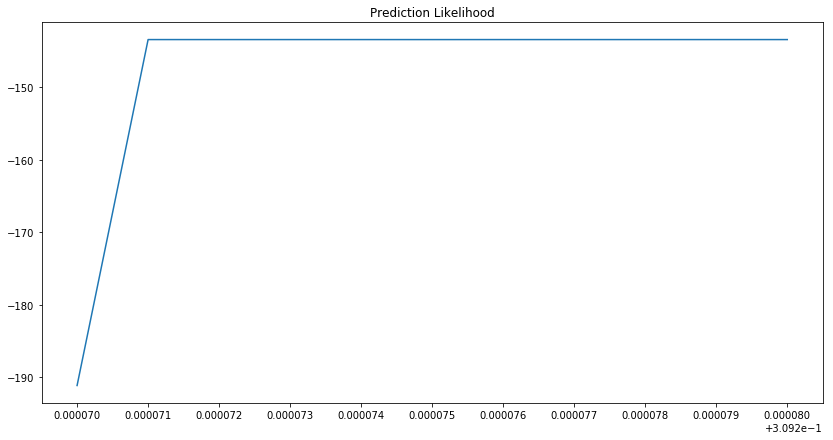

In [64]:
plt.figure(figsize=(14,7))
plt.title("Prediction Likelihood")
plt.xticks(lambda_es)
plt.plot(lambda_es, pred_l_logit)
plt.show()

In [65]:

#params_optimizied_logit_1, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit_1, x0 = params, fprime = grad_objective_logit_1, args = (transformer.noise_variance_, x, y, latent_dim, lambda_e, opt))

params_optimizied_logit_1, obj_value_logit_1, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e_1, opt))
params_optimizied_logit_2, obj_value_logit_2, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e_2, opt))


f_logit_1, bias_logit_1, cov_noise_logit_1, w_logit_1 = decode_parameters(params_optimizied_logit_1, x_dim, latent_dim, opt)
ll_1=  compute_ll(f_logit_1, bias_logit_1, cov_noise_logit_1, x)
pl_1 = compute_pl_logit(f_logit_1, bias_logit_1, cov_noise_logit_1, w_logit_1, x, y) 

f_logit_2, bias_logit_2, cov_noise_logit_2, w_logit_2 = decode_parameters(params_optimizied_logit_2, x_dim, latent_dim, opt)
ll_2=  compute_ll(f_logit_2, bias_logit_2, cov_noise_logit_2, x)
pl_2 = compute_pl_logit(f_logit_2, bias_logit_2, cov_noise_logit_2, w_logit_2, x, y) 

#lambda_es = np.arange(0,1,0.1)
lambda_es = np.array([lambda_e_1, lambda_e_2])
obj_values_logit = np.ones((2, lambda_es.shape[0]))

for i in range(lambda_es.shape[0]):
    obj_values_logit[0,i] = objective_logit(params_optimizied_logit_1, x, y, latent_dim, lambda_es[i], opt)
    obj_values_logit[1,i] = objective_logit(params_optimizied_logit_2, x, y, latent_dim, lambda_es[i], opt)

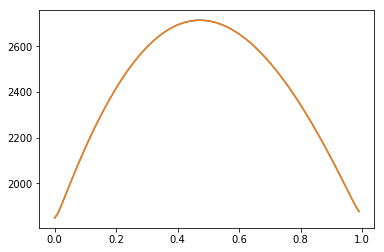

In [70]:
interp = np.arange(0, 1.0, 0.01)
obj1 = [objective_logit(params_optimizied_logit_1 * i + (1.0-i) * params_optimizied_logit_2, x, y, latent_dim, lambda_e_1, opt) for i in np.arange(0, 1, 0.01)]
obj2 = [objective_logit(params_optimizied_logit_1 * i + (1.0-i) * params_optimizied_logit_2, x, y, latent_dim, lambda_e_2, opt) for i in np.arange(0, 1, 0.01)]

plt.plot(interp, obj1)
plt.plot(interp, obj2)

[[ 1.        ]
 [-7.39114372]]
[[ 1.        ]
 [-7.27889487]]
[[ 1.        ]
 [-7.16664602]]
[[ 1.        ]
 [-7.05439718]]
[[ 1.        ]
 [-6.94214833]]
[[ 1.        ]
 [-6.82989948]]
[[ 1.        ]
 [-6.71765063]]
[[ 1.        ]
 [-6.60540179]]
[[ 1.        ]
 [-6.49315294]]
[[ 1.        ]
 [-6.38090409]]
[[ 1.        ]
 [-6.26865524]]
[[ 1.       ]
 [-6.1564064]]
[[ 1.        ]
 [-6.04415755]]
[[ 1.       ]
 [-5.9319087]]
[[ 1.        ]
 [-5.81965985]]
[[ 1.      ]
 [-5.707411]]
[[ 1.        ]
 [-5.59516216]]
[[ 1.        ]
 [-5.48291331]]
[[ 1.        ]
 [-5.37066446]]
[[ 1.        ]
 [-5.25841561]]
[[ 1.        ]
 [-5.14616677]]
[[ 1.        ]
 [-5.03391792]]
[[ 1.        ]
 [-4.92166907]]
[[ 1.        ]
 [-4.80942022]]
[[ 1.        ]
 [-4.69717138]]
[[ 1.        ]
 [-4.58492253]]
[[ 1.        ]
 [-4.47267368]]
[[ 1.        ]
 [-4.36042483]]
[[ 1.        ]
 [-4.24817598]]
[[ 1.        ]
 [-4.13592714]]
[[ 1.        ]
 [-4.02367829]]
[[ 1.        ]
 [-3.91142944]]
[[ 1.        ]
 

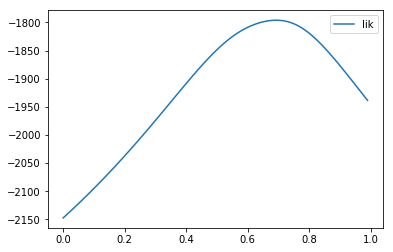

In [111]:
interp = np.arange(-0., 1.0, 0.01)
lik =[]
plik = []
obj = []
grad_objective_logit_1 = grad(objective_logit_1)
params_start= np.random.rand(params_size)
for i in interp:
    slope = 3.83374105 * i + (1.0 - i) * -7.39114372
    f_logit = np.array([1., slope]).reshape((2,1))
    print f_logit
    params_optimizied_logit, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit_1, x0 = params_start, fprime = grad_objective_logit_1, args = (f_logit, x, y, latent_dim, lambda_e_1, opt))
    _, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
    ll =  compute_ll(f_logit, bias_logit, cov_noise_logit, x)
    pl = compute_pl_logit(f_logit, bias_logit, cov_noise_logit, w_logit, x, y) 
    lik.append(ll)
    plik.append(pl)
    obj.append(obj_value_logit)
    
plt.plot(interp, lik, label='lik')
#plt.plot(interp, plik, label='predictive')
plt.legend()

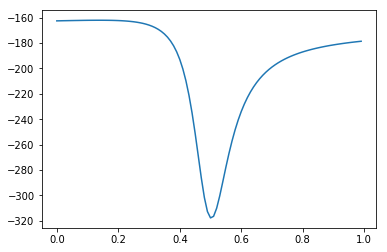

In [107]:
plt.plot(interp, plik, label='predictive')


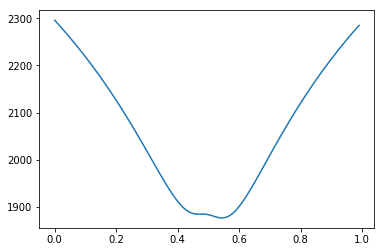

In [108]:
plt.plot(interp, obj)

In [109]:
obj[0], obj[-1]

(2295.7235219319064, 2284.8470160978873)

In [66]:
obj_values_logit

array([[1873.99909438, 1874.0010054 ],
       [1847.97670168, 1847.97813646]])

In [41]:
w_logit_1

array([-2.04086494e-04,  8.54543742e-01])

In [43]:
w_logit_2

array([2.31926085e-02, 3.03785937e+02])

In [40]:
lambda_es

array([0.3, 0.4])

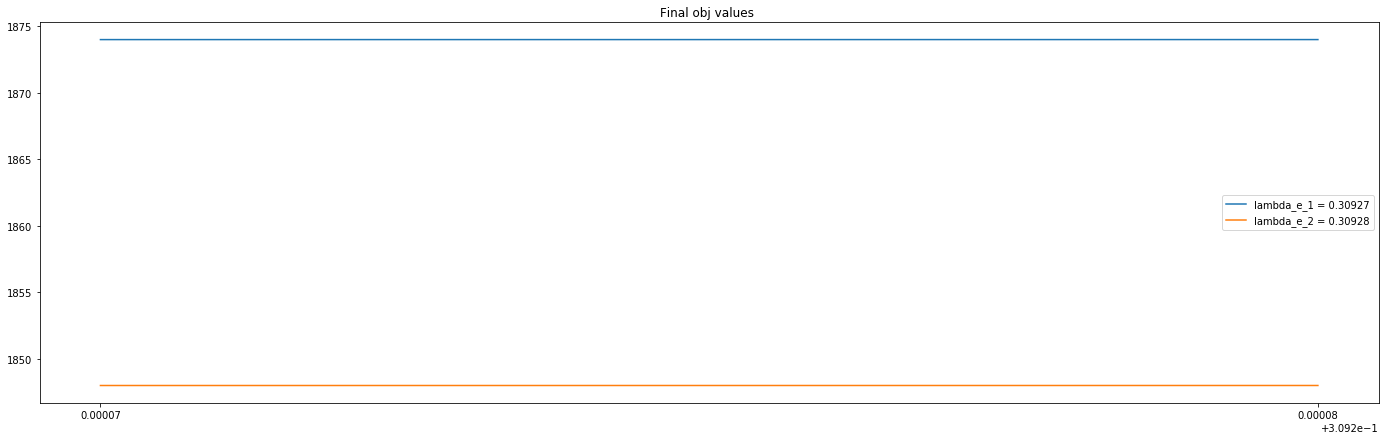

In [67]:
plt.figure(figsize=(24,7))
plt.title("Final obj values ")
plt.xticks(lambda_es)
plt.plot(lambda_es, obj_values_logit[0, :], label = "lambda_e_1 = {}".format(lambda_e_1))
plt.plot(lambda_es, obj_values_logit[1, :], label = "lambda_e_2 = {}".format(lambda_e_2))
plt.legend()
plt.show()

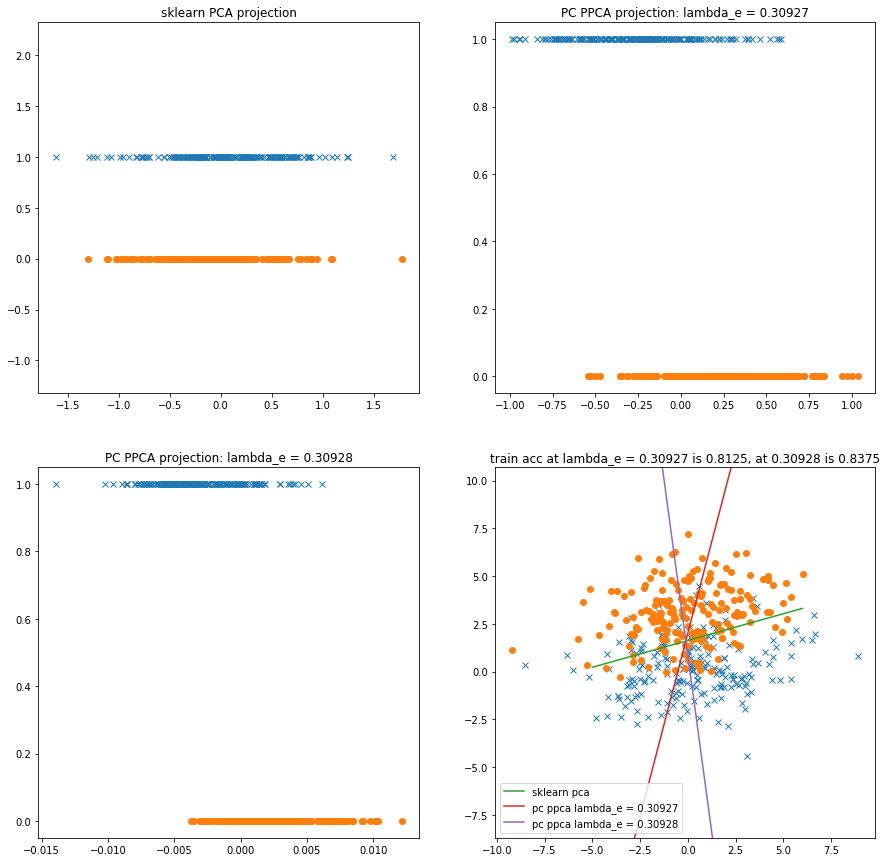

In [128]:
plt.figure(figsize=(15,15))

plt.subplot(221) 
#plt.axis('equal')

plt.axis('equal')
plt.title("sklearn PCA projection")
x_proj_sklearn = transform(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

plt.plot(x_proj_sklearn[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_sklearn[n_samples_class:,0], np.zeros(n_samples_class), 'o')


plt.subplot(222) 
plt.title("PC PPCA projection: lambda_e = {}".format(lambda_e_1))
x_proj_logit_1 = transform(f_logit_1, bias_logit_1, cov_noise_logit_1, x)
plt.plot(x_proj_logit_1[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit_1[n_samples_class:], np.zeros(n_samples_class), 'o')


plt.subplot(223)
plt.title("PC PPCA projection: lambda_e = {}".format(lambda_e_2))
x_proj_logit_2 = transform(f_logit_2, bias_logit_2, cov_noise_logit_2, x)
plt.plot(x_proj_logit_2[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit_2[n_samples_class:], np.zeros(n_samples_class), 'o')


plt.subplot(224) 
plt.axis('equal')
clf_pc_1 = LogisticRegression().fit(x_proj_logit_1, y)
acc_scores_1 = clf_pc.score(x_proj_logit_1, y)
clf_pc_2 = LogisticRegression().fit(x_proj_logit_2, y)
acc_scores_2 = clf_pc.score(x_proj_logit_2, y)

plt.title("train acc at lambda_e = {} is {}, at {} is {}".format(lambda_e_1, acc_scores_1, lambda_e_2, acc_scores_2))
    
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

x_lim_1 = -5
x_lim_2 = 7


a =  np.array(range(x_lim_1, x_lim_2)) 

b_pc_fa_logit_1 = f_logit_1[1]/f_logit_1[0]*(a + bias_logit_1[0]) + bias_logit_1[1]
b_pc_fa_logit_2 = f_logit_2[1]/f_logit_2[0]*(a + bias_logit_2[0]) + bias_logit_2[1]
b_sklearn = f_sklearn[1]/f_sklearn[0]*(a + bias_sklearn [0]) + bias_sklearn [1]

plt.plot(a, b_sklearn, label='sklearn pca')
plt.plot(a, b_pc_fa_logit_1, label="pc ppca lambda_e = {}".format(lambda_e_1))
plt.plot(a, b_pc_fa_logit_2, label="pc ppca lambda_e = {}".format(lambda_e_2))
plt.ylim(x_lim_1,x_lim_2)

plt.legend()
plt.savefig("data_lambda_e_1={}_lambda_e_2={}_logistic_pc_ppca_vs_sklearn_pca.png".format(lambda_e_1, lambda_e_2))

plt.show()


In [ ]:
b_pc_fa_logit_1[(b_pc_fa_logit_1<np.max(x[:,1] and b_pc_fa_logit_1>np.min(x[:,1]))].shape

In [ ]:
b_pc_fa_logit_1[b_pc_fa_logit_1[b_pc_fa_logit_1>np.min(x[:,1])]< np.max(x[:,1])] 

In [112]:
print ll_1
print pl_1
print ll_2

print pl_2

print "Final parameters_logit 1"
print "logit slope\n", f_logit_1[1]/f_logit_1[0]
print "F:\n", f_logit_1
print "bias for x:\n", bias_logit_1
print "var :\n",cov_noise_logit_1
print "bias for y:\n", w_logit_1[0]
print "logistic regression weights:\n", w_logit_1[1:]

print "Final parameters_logit 2"
print "logit slope\n", f_logit_2[1]/f_logit_2[0]
print "F:\n", f_logit_2
print "bias for x:\n", bias_logit_2
print "cov_noise matrix:\n", cov_noise_logit_2
print "bias for y:\n", w_logit_2[0]
print "logistic regression weights:\n", w_logit_2[1:]

-1814.8968269996058
-191.10249094956765
-1803.6031173335384
-143.47846329083077
Final parameters_logit 1
logit slope
[3.83374105]
F:
[[0.32686296]
 [1.25310795]]
bias for x:
[0.1083901  1.58822296]
var :
[[5.04802491 0.        ]
 [0.         5.04802491]]
bias for y:
0.03681210834733342
logistic regression weights:
[2.69917484]
Final parameters_logit 2
logit slope
[-7.39114372]
F:
[[-0.00155828]
 [ 0.01151744]]
bias for x:
[0.10232423 1.59917753]
cov_noise matrix:
[[5.32021784 0.        ]
 [0.         5.32021784]]
bias for y:
0.030419197855576563
logistic regression weights:
[613.69543556]


In [113]:
t = np.array([[ 1.        ], [-7.39114372]])

In [114]:
np.einsum("dl,ml->dm",t,t)

array([[ 1.        , -7.39114372],
       [-7.39114372, 54.62900549]])

In [116]:
np.einsum("dl,ml->dm",f_logit_2,f_logit_2)

array([[ 2.42822119e-06, -1.79473318e-05],
       [-1.79473318e-05,  1.32651309e-04]])

In [ ]:
lambda_e_1 = 0.30927
lambda_e_2 = 0.30928
step  = 0.000001
lambda_es = np.arange(lambda_e_1,lambda_e_2,step)
acc_scores = np.zeros(lambda_es.shape[0])
obj_values_logit = np.zeros(lambda_es.shape[0])
ll_logit = np.zeros(lambda_es.shape[0])
pred_l_logit = np.zeros(lambda_es.shape[0])

#grad_objective_logit_1 = grad(objective_logit_1, argnum = 0)
#hess_objective_logit_1 = hessian(objective_logit_1, argnum = 0)

def callback(params):
    print objective_logit_1(params, transformer.noise_variance_, x, y, latent_dim, lambda_es[i], opt)
    print grad_objective_logit_1(params, transformer.noise_variance_, x, y, latent_dim, lambda_es[i], opt)
    #print params[1]/params[0]
    #print params[-2],"-",params[-1]
    pass
    print '\n'
grad_objective_logit = grad(objective_logit, argnum = 0)


for i in range(lambda_es.shape[0]):
    params_optimizied_logit, obj, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_es[i], opt))#, callback=callback)
    f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
    #cov_noise_logit = np.diag(np.ones(x_dim)*transformer.noise_variance_)
    x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
    clf_pc = LogisticRegression().fit(x_proj_logit, y)
    acc_scores[i] = clf_pc.score(x_proj_logit, y)
    ll_logit[i] = compute_ll(f_logit, bias_logit, cov_noise_logit, x)
    obj_values_logit[i]=  obj
    pred_l_logit[i] =  compute_pl_logit(f_logit, bias_logit, cov_noise_logit, w_logit, x, y) 